---

**Load essential libraries**

---

In [1]:
import numpy as np
import sys
import random
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras import backend as K

2.12.1


---

Mount Google Drive if running on Colab

---

In [3]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    # Change path below starting from /content/drive/MyDrive/Colab Notebooks/
    # depending on how data is organized inside your Colab Notebooks folder in
    # Google Drive
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/EvenSem2024MAHE'
    DATA_DIR = DIR+'/Data/'
else:
    DATA_DIR = 'Data/'

---

Load MNIST Data

---

In [4]:
## Load MNIST data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

num_labels = len(np.unique(y_train))
num_features = X_train.shape[1]
num_samples = X_train.shape[0]

# One-hot encode class labels
Y_train = tf.keras.utils.to_categorical(y_train)
Y_test = tf.keras.utils.to_categorical(y_test)

# Normalize the samples (images) using the training data
xmax = np.amax(X_train)
xmin = np.amin(X_train)
X_train = (X_train - xmin) / (xmax - xmin) # all train features turn into a number between 0 and 1
X_test = (X_test - xmin)/(xmax - xmin)

print('MNIST set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))
print('Number of output labels = %d'%(num_labels))

MNIST set
---------------------
Number of training samples = 60000
Number of features = 784
Number of output labels = 10


---

Hyperparameters for the model

---

In [6]:
## Hyperparameters for the model
batch_size = 256
max_epochs = 50
learning_rate = 1e-03
reg_strength = 0.1

---

We have looked at 2 different approaches to build custom models using TensorFlow 2:

1. sequential API
2. model subclassing ([Making new layers and models via subclassing](https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing))

The 3rd, and the last approach is via the functional API.

---

---

**Approach-1**: here we build the model using the sequential API of TensorFlow Keras, compile, and train it.

---

In [7]:
# Define model architecture (2 layers, 128 nodes in hidden layer)
model = Sequential()
model.add(Dense(128,
                dtype = 'float64',
                activation = tf.nn.leaky_relu,
                kernel_regularizer = tf.keras.regularizers.l2(l2 = reg_strength)
                ))
model.add(Dense(num_labels,
                dtype = 'float64',
                activation = tf.keras.activations.softmax,
                kernel_regularizer = tf.keras.regularizers.l2(l2 = reg_strength)
                ))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate) # optimizer
loss_fn = tf.keras.losses.CategoricalCrossentropy()  # loss function
model.compile(optimizer = opt, loss = loss_fn, metrics = ['acc'])

# Train model and simultaneously test on the test set
history = model.fit(X_train, Y_train,
                    batch_size = batch_size,
                    epochs = max_epochs,
                    validation_data = (X_test, Y_test))

Epoch 1/50
235/235 [==============================] - 4s 11ms/step - loss: 4.5178 - acc: 0.7657 - val_loss: 1.9491 - val_acc: 0.8009
Epoch 2/50
235/235 [==============================] - 2s 9ms/step - loss: 1.9492 - acc: 0.7567 - val_loss: 1.9214 - val_acc: 0.7705
Epoch 3/50
235/235 [==============================] - 2s 9ms/step - loss: 1.9342 - acc: 0.7457 - val_loss: 1.9113 - val_acc: 0.7370
Epoch 4/50
235/235 [==============================] - 2s 9ms/step - loss: 1.9281 - acc: 0.7423 - val_loss: 1.9099 - val_acc: 0.7376
Epoch 5/50
235/235 [==============================] - 2s 9ms/step - loss: 1.9257 - acc: 0.7400 - val_loss: 1.9103 - val_acc: 0.7258
Epoch 6/50
235/235 [==============================] - 2s 9ms/step - loss: 1.9236 - acc: 0.7409 - val_loss: 1.9040 - val_acc: 0.7468
Epoch 7/50
235/235 [==============================] - 2s 9ms/step - loss: 1.9234 - acc: 0.7373 - val_loss: 1.9087 - val_acc: 0.7195
Epoch 8/50
235/235 [==============================] - 2s 9ms/step - loss: 1

---

Plot train and test loss vs. epoch and train and test accuracies vs. epoch

---

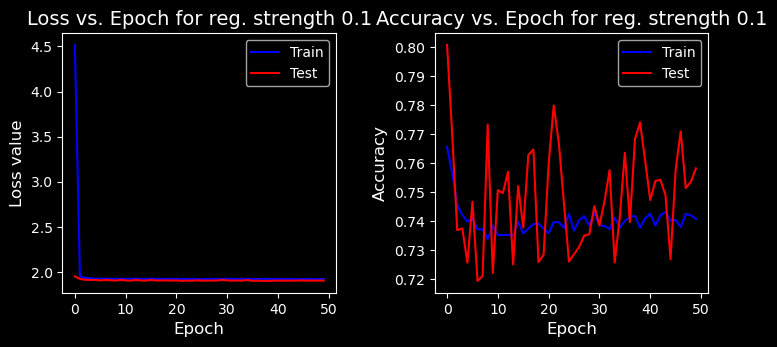

In [8]:
# Plot train and test loss vs. epoch and
# train and test accuracies vs. epoch:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
fig.tight_layout(pad = 4.0)
ax[0].plot( history.history['loss'], 'b', label = 'Train')
ax[0].plot( history.history['val_loss'], 'r', label = 'Test')
ax[0].set_xlabel('Epoch', fontsize = 12)
ax[0].set_ylabel('Loss value', fontsize = 12)
ax[0].legend()
ax[0].set_title(f'Loss vs. Epoch for reg. strength {reg_strength}', fontsize = 14);

ax[1].plot( history.history['acc'], 'b', label = 'Train')
ax[1].plot( history.history['val_acc'], 'r', label = 'Test')
ax[1].set_xlabel('Epoch', fontsize = 12)
ax[1].set_ylabel('Accuracy', fontsize = 12)
ax[1].legend()
ax[1].set_title('Accuracy vs. Epoch for reg. strength 0.1', fontsize = 14);

---

**Approach-2**: here we build the model by subclassing the TensorFlow Keras $\texttt{Model}$ class followed by definition of of layers in $\texttt{__init__}$ and implementation of the model's forward pass in $\texttt{call()}$.

---

In [9]:
## Define 2-layer neural network architecture with 128 nodes in the hidden layer
# Define model
class Model(tf.keras.models.Model):
    def __init__(self):
        super(Model, self).__init__()
        initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)
        self.layer1 = tf.keras.layers.Dense(128,
                                            dtype = 'float64',
                                            bias_initializer = initializer,
                                            activation = tf.nn.leaky_relu,
                                            kernel_regularizer = tf.keras.regularizers.l2(l2 = reg_strength)
                                            )
        self.layer2 = tf.keras.layers.Dense(num_labels,
                                            dtype = 'float64',
                                            bias_initializer = initializer,
                                            activation = tf.keras.activations.softmax,
                                            kernel_regularizer = tf.keras.regularizers.l2(l2 = reg_strength)
                                            )

    # Forward pass for the model
    def call(self, inputs):
        a = self.layer1(inputs)
        a = self.layer2(a)
        return a

---

Compile and train the model.

---

In [10]:
## Compile model
model = Model()
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate) # optimizer
loss_fn = tf.keras.losses.CategoricalCrossentropy()  # loss function
model.compile(optimizer = opt, loss = loss_fn, metrics = ['acc'])

# Train model and simultaneously test on the test set
history = model.fit(X_train, Y_train,
                    batch_size = 100,
                    epochs = max_epochs,
                    validation_data = (X_test, Y_test))

Epoch 1/50


c:\Users\adity\anaconda3\Lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


600/600 [==============================] - 5s 6ms/step - loss: 3.0008 - acc: 0.7500 - val_loss: 1.9228 - val_acc: 0.7451
Epoch 2/50
600/600 [==============================] - 4s 6ms/step - loss: 1.9344 - acc: 0.7341 - val_loss: 1.9127 - val_acc: 0.7288
Epoch 3/50
600/600 [==============================] - 3s 6ms/step - loss: 1.9305 - acc: 0.7289 - val_loss: 1.9101 - val_acc: 0.7646
Epoch 4/50
600/600 [==============================] - 4s 6ms/step - loss: 1.9287 - acc: 0.7285 - val_loss: 1.9110 - val_acc: 0.7354
Epoch 5/50
600/600 [==============================] - 4s 7ms/step - loss: 1.9273 - acc: 0.7323 - val_loss: 1.9143 - val_acc: 0.7622
Epoch 6/50
600/600 [==============================] - 4s 7ms/step - loss: 1.9280 - acc: 0.7265 - val_loss: 1.9039 - val_acc: 0.7574
Epoch 7/50
600/600 [==============================] - 4s 6ms/step - loss: 1.9268 - acc: 0.7296 - val_loss: 1.9040 - val_acc: 0.7272
Epoch 8/50
600/600 [==============================] - 4s 6ms/step - loss: 1.9267 - acc:

---

In **Approach-2** where we subclassed the Model class, we can also explicitly write down the optimization step using $\texttt{GradientTape()}$ and train the model

---

In [11]:
## Convert numpy to tf.data.datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(batch_size)

In [12]:
## Function to compute gradient of loss and update weights
@tf.function
def train(model, loss_fn, opt, input):
  with tf.GradientTape() as g:
    pred = model(input[0])
    loss_batch = loss_fn(input[1], pred)
  gradients = g.gradient(loss_batch, model.trainable_variables)
  opt.apply_gradients(zip(gradients, model.trainable_variables))
  return loss_batch

In [13]:
# Create neural network model with 128 nodes in the hidden layer
model = Model()
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate) # optimizer
loss_fn = tf.keras.losses.CategoricalCrossentropy()  # loss function

# Varible to store training loss per epoch
loss_train_epoch = tf.keras.metrics.Mean()
loss_train_epoch_plot = np.empty(max_epochs)

# Iterate over epochs
for epoch in range(max_epochs):
  for step, train_batch_features in enumerate(train_dataset):
    loss_batch = train(model, loss_fn, opt, train_batch_features)
    # Append training loss
    loss_train_epoch(loss_batch)
  loss_train_epoch_plot[epoch] = loss_train_epoch.result().numpy()
  print(f'Epoch {epoch+1}, loss = {loss_train_epoch_plot[epoch]}')

Epoch 1, loss = 0.47376400232315063
Epoch 2, loss = 0.36169642210006714
Epoch 3, loss = 0.3081967532634735
Epoch 4, loss = 0.2730792164802551
Epoch 5, loss = 0.24704031646251678
Epoch 6, loss = 0.22646203637123108
Epoch 7, loss = 0.20955626666545868
Epoch 8, loss = 0.1953057497739792
Epoch 9, loss = 0.18304382264614105
Epoch 10, loss = 0.17233946919441223
Epoch 11, loss = 0.16287991404533386
Epoch 12, loss = 0.15444223582744598
Epoch 13, loss = 0.14684973657131195
Epoch 14, loss = 0.13997352123260498
Epoch 15, loss = 0.13370302319526672
Epoch 16, loss = 0.1279580444097519
Epoch 17, loss = 0.12266694009304047
Epoch 18, loss = 0.11777739971876144
Epoch 19, loss = 0.11324241757392883
Epoch 20, loss = 0.10901989042758942
Epoch 21, loss = 0.10507941246032715
Epoch 22, loss = 0.1013866439461708
Epoch 23, loss = 0.09792371839284897
Epoch 24, loss = 0.09466643631458282
Epoch 25, loss = 0.09159804880619049
Epoch 26, loss = 0.08870183676481247
Epoch 27, loss = 0.08596698194742203
Epoch 28, loss 

---

**Approach-3**: here we build the model using the functional API of TensorFlow.

---

---

Siamese neural network

![](https://dsm01pap002files.storage.live.com/y4m4YOFCC_sbCAbXCq7NQU6A2WruYAWuAighVI6h0pyQ8cPKVLxXOsmoDld5x30YlDiYqN_8O92TvfkGAoj3mGOWI8a3zazkfvVjccQZdimepRQ6a3QTe7CjNtUgXDp5xGZgseO_ODki5iA1lgikBzCy0vg52LJwyvzfLsT7ZjxapEy9Ej2aYbN27m0fdesXHHA?width=415&height=372&cropmode=none)

---

In [14]:
## Load MNIST dataset without flattening (reshaping) the images
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [15]:
## Normalize the samples (images) using the training data
xmax = np.amax(X_train)
xmin = np.amin(X_train)
X_train = (X_train - xmin) / (xmax - xmin) # all train features turn into a number between 0 and 1
X_test = (X_test - xmin)/(xmax - xmin)



---


**Function to create pairs of images** (for function source, [click here](https://keras.io/examples/vision/siamese_contrastive/))

We will train the model to differentiate between digits of different classes. For example, digit 0 needs to be differentiated from the rest of the digits (1 through 9), digit 1 - from 0 and 2 through 9, and so on. To carry this out, we will select N random images from class A (for example, for digit 0) and pair them with N random images from another class B (for example, for digit 1). Then, we can repeat this process for all classes of digits (until digit 9). Once we have paired digit 0 with other digits, we can repeat this process for the remaining classes for the rest of the digits (from 1 until 9).


---



In [16]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")

---

Create train and test image pairs

---

In [17]:
# Make train pairs
X_train_pairs, y_train_pairs = make_pairs(X_train, y_train)

# Make test pairs
X_test_pairs, y_test_pairs = make_pairs(X_test, y_test)



---

Function for visualizing the paired data (for function source, [click here](https://keras.io/examples/vision/siamese_contrastive/))


---



In [18]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()



---


Visualize some training samples. Note that the label is 1 if both pairs if images are the same digits and 0 otherwise.


---



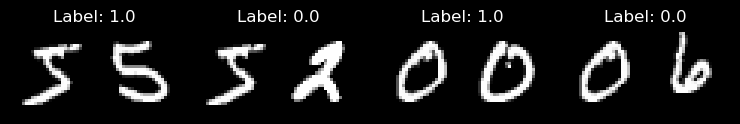

In [19]:
visualize(X_train_pairs[:-1], y_train_pairs[:-1], to_show = 4, num_col = 4)